In [1]:
from utils import (create_embeddings,
                   calc_ann_metric_rerank,
                   display_random_item
                   )
import pandas as pd
import cv2 as cv2
from tqdm.notebook import tqdm
import torch
from models import get_model2
from torchvision import transforms
from annoy import AnnoyIndex
from transformers import AutoTokenizer, AutoModel

In [2]:
company_data = pd.read_csv("company_data.csv")
comparable_data = pd.read_csv("comparable_data.csv")

In [3]:
company_data.head(3)

title   price            cat_1  \
0                       Беговая дорожка SOLE F65  169900  Беговые дорожки   
1         Беговая дорожка OXYGEN M-CONCEPT SPORT  109990  Беговые дорожки   
2  Беговая дорожка OXYGEN FITNESS RUNUP GROOVE A   63990  Беговые дорожки   

                           cat_2   cat_3  \
0  Электрические беговые дорожки    SOLE   
1  Электрические беговые дорожки  OXYGEN   
2  Электрические беговые дорожки  OXYGEN   

                                      caracteristics  \
0  Тип дорожки:для домашнего использования Скорос...   
1  Тип дорожки:электрическая Скорость:1 - 14 км/ч...   
2  Тип дорожки:домашняя, электрическая Скорость:1...   

                                          img_ref            target     dealer  
0  images/begovye_dorozhki/1_sportdoma_19512.jpeg  begovye_dorozhki  sportdoma  
1  images/begovye_dorozhki/2_sportdoma_17451.jpeg  begovye_dorozhki  sportdoma  
2  images/begovye_dorozhki/3_sportdoma_22172.jpeg  begovye_dorozhki  sportdoma

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
default_transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

In [6]:
model = get_model2()
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
company_img_embeddings = create_embeddings(
    "company_data.csv", model, default_transform, device
)
company_emb_flat = [x for xs in company_img_embeddings for x in xs]
database_img_embeddings = create_embeddings(
    "comparable_data.csv", model, default_transform, device
)
database_emb_flat = [x for xs in database_img_embeddings for x in xs]

  0%|          | 0/984 [00:00<?, ?it/s]

  0%|          | 0/13718 [00:00<?, ?it/s]

In [8]:
forest = AnnoyIndex(len(database_emb_flat[0]), metric="angular")
for i, item in tqdm(enumerate(database_emb_flat)):
    forest.add_item(i, item.cpu().detach().tolist())
forest_labels = comparable_data["target"].tolist()
forest.build(50)
forest.save("forest_resnet_not_trained.ann")

0it [00:00, ?it/s]

True

In [9]:
model_name = "cointegrated/rubert-tiny2"
text_model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
text_model.to(device)

c:\Users\Kate\Desktop\cv_project\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(83828, 312, padding_idx=0)
    (position_embeddings): Embedding(2048, 312)
    (token_type_embeddings): Embedding(2, 312)
    (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-2): 3 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=312, out_features=312, bias=True)
            (key): Linear(in_features=312, out_features=312, bias=True)
            (value): Linear(in_features=312, out_features=312, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=312, out_features=312, bias=True)
            (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)

In [10]:
calc_ann_metric_rerank(k_img=40, k_text=10, forest=forest,
                       query_tensors=company_emb_flat, query_df=company_data,
                       database_df=comparable_data, text_model= text_model,
                       tokenizer=tokenizer)

  0%|          | 0/984 [00:00<?, ?it/s]

c:\Users\Kate\Desktop\cv_project\.venv\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


grebnye_trenazhery acc at 10: 0.946
ellipticheskie_trenazhery acc at 10: 0.9968
velotrenazhery acc at 10: 0.9862
begovye_dorozhki acc at 10: 0.9926
steppery acc at 10: 0.3491
trenazhery_na_svobodnykh_vesakh acc at 10: 0.7102
multistantsii acc at 10: 0.65
Total acc at 10: 0.8677


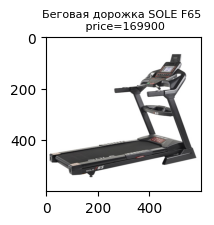

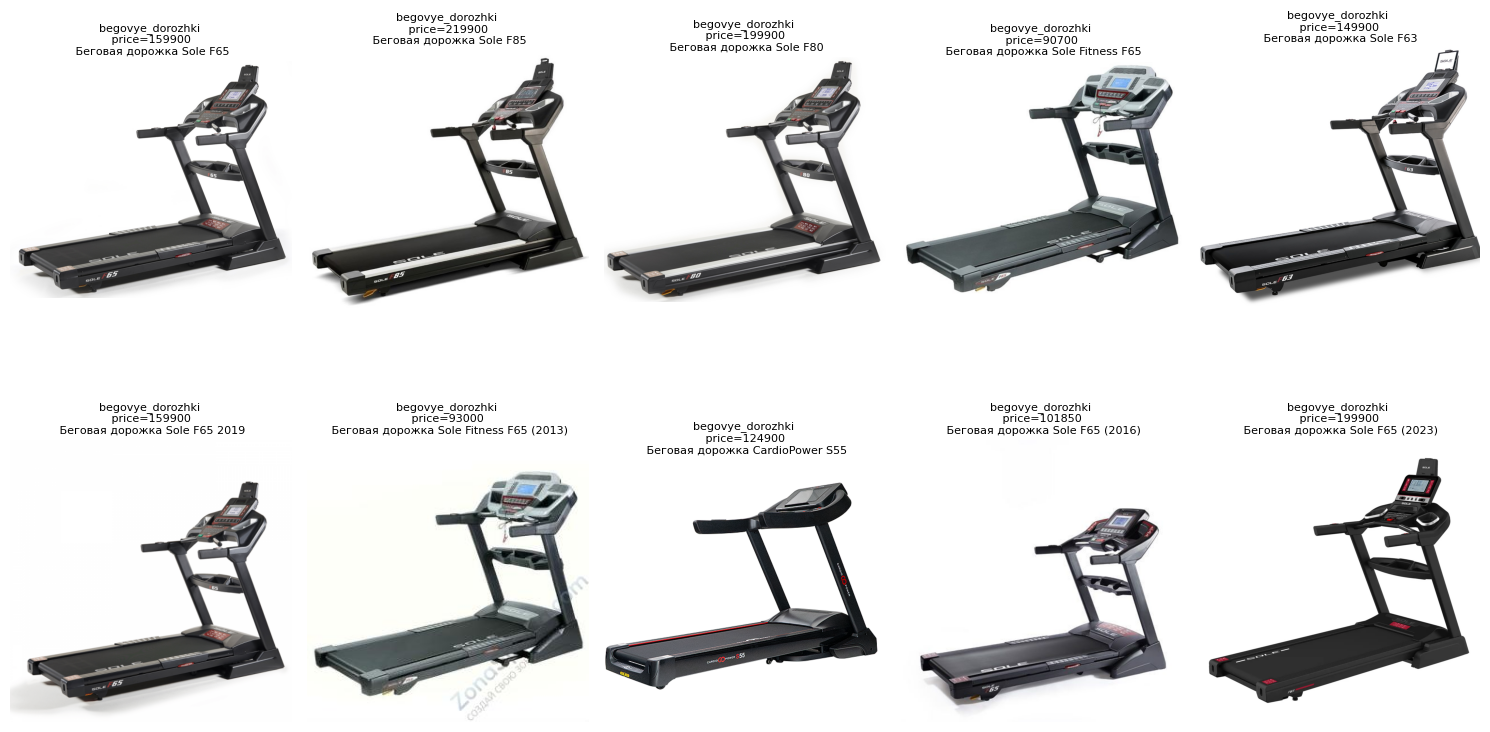

In [11]:
display_random_item(
    k=10,
    k_img=50,
    k_text=10,
    random_idx=0,
    method="combo",
    company_data=company_data,
    company_emb=company_emb_flat,
    database_emb=database_emb_flat,
    comparable_data=comparable_data,
    forest=forest,
    text_model=text_model,
    tokenizer=tokenizer,
    info_used="title_only",
)

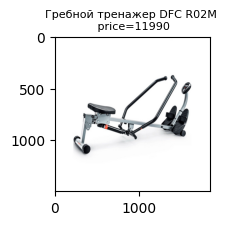

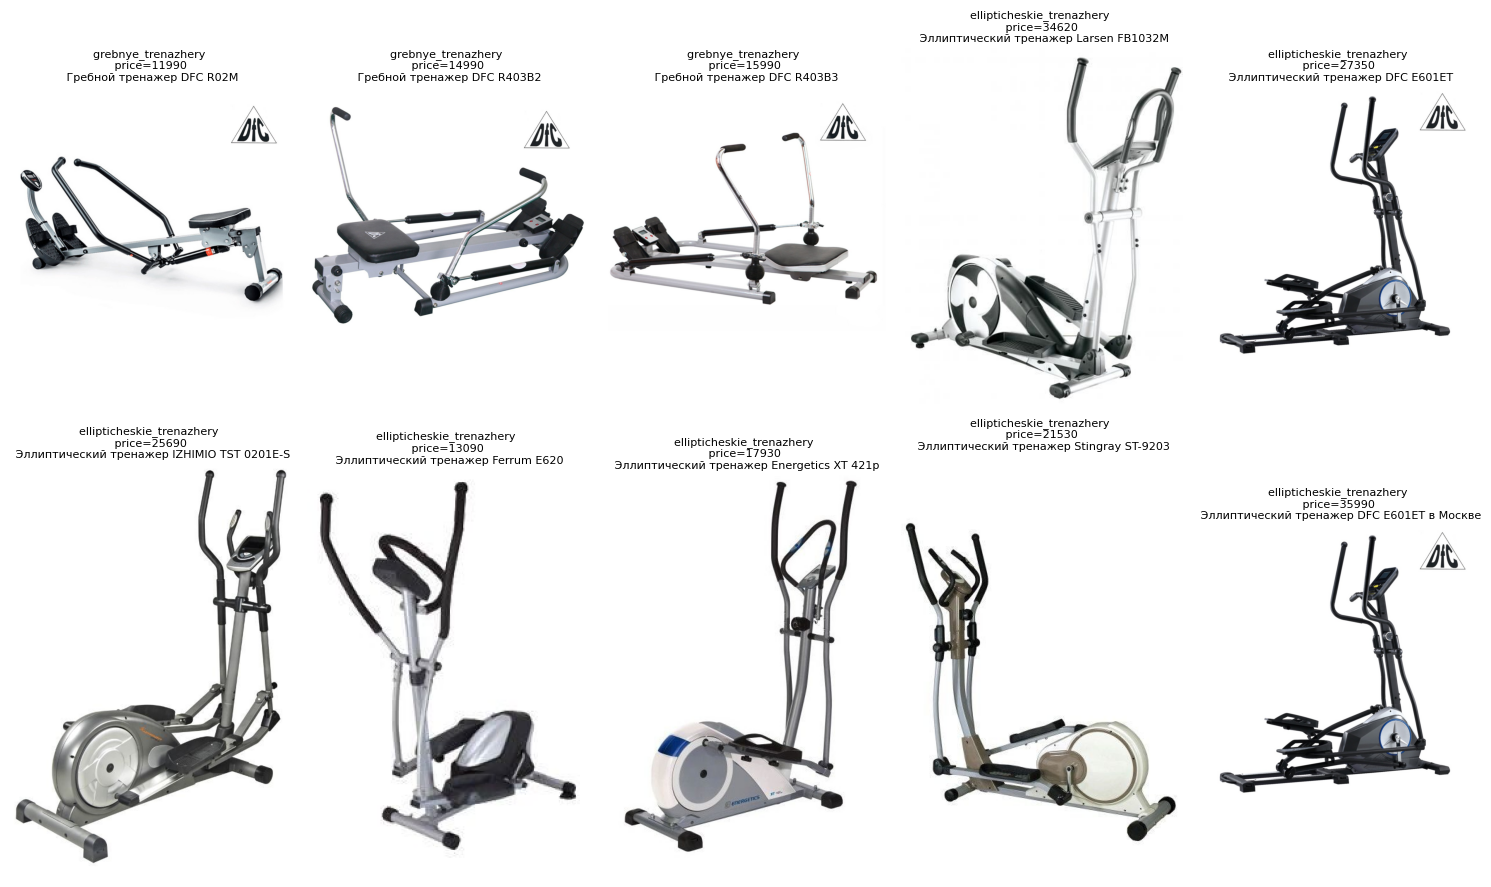

In [12]:
display_random_item(
    k=10,
    k_img=50,
    k_text=10,
    random_idx=500,
    method="combo",
    company_data=company_data,
    company_emb=company_emb_flat,
    database_emb=database_emb_flat,
    comparable_data=comparable_data,
    forest=forest,
    text_model=text_model,
    tokenizer=tokenizer,
    info_used="title_only",
)

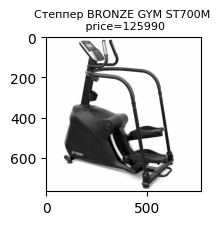

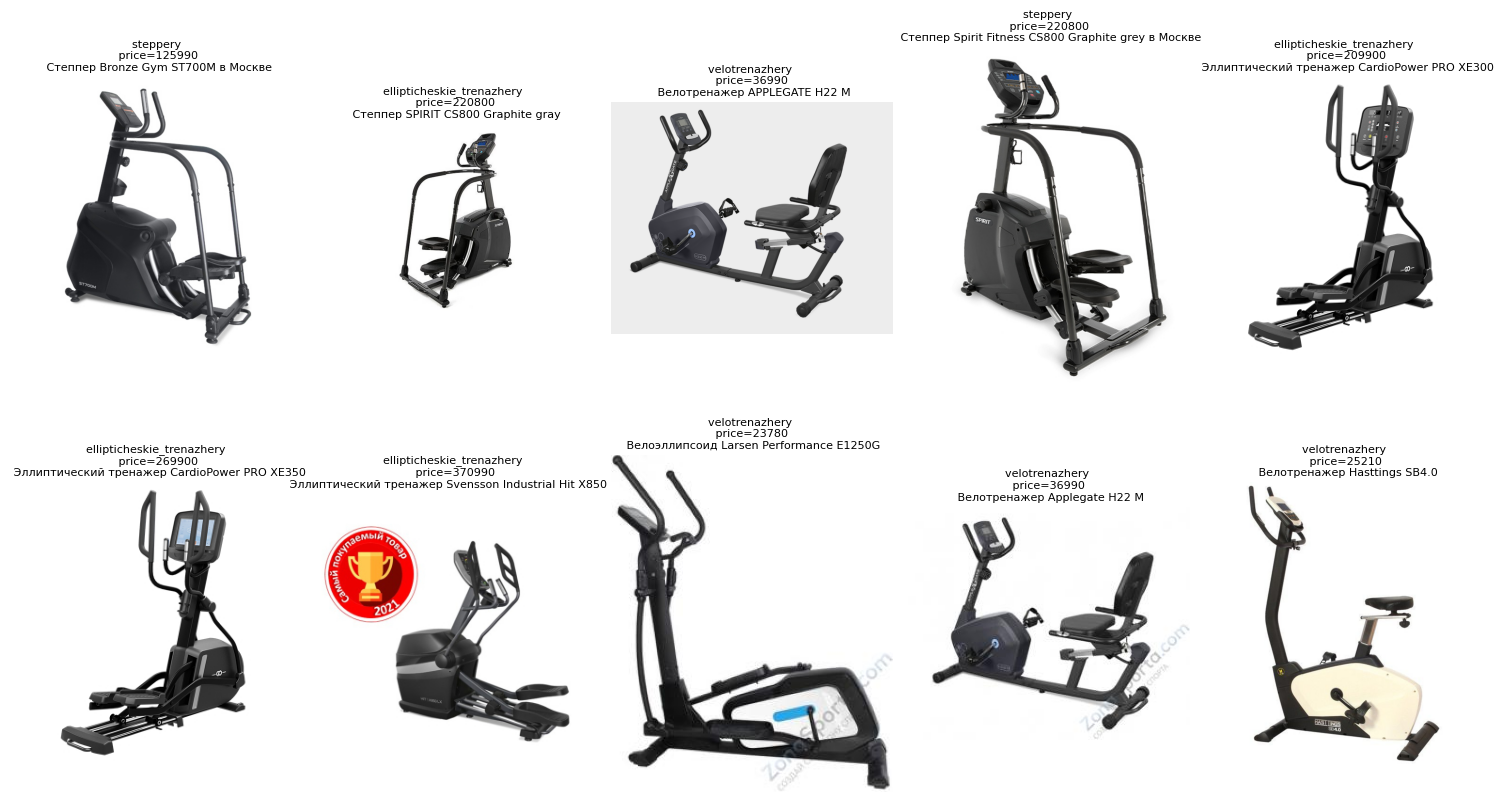

In [13]:
display_random_item(
    k=10,
    k_img=50,
    k_text=10,
    random_idx=626,
    method="combo",
    company_data=company_data,
    company_emb=company_emb_flat,
    database_emb=database_emb_flat,
    comparable_data=comparable_data,
    forest=forest,
    text_model=text_model,
    tokenizer=tokenizer,
    info_used="title_only",
)

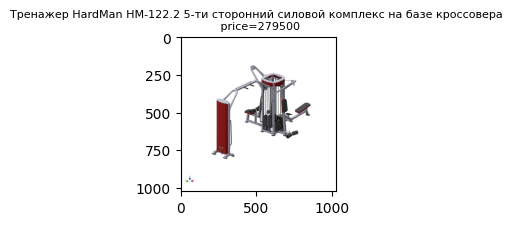

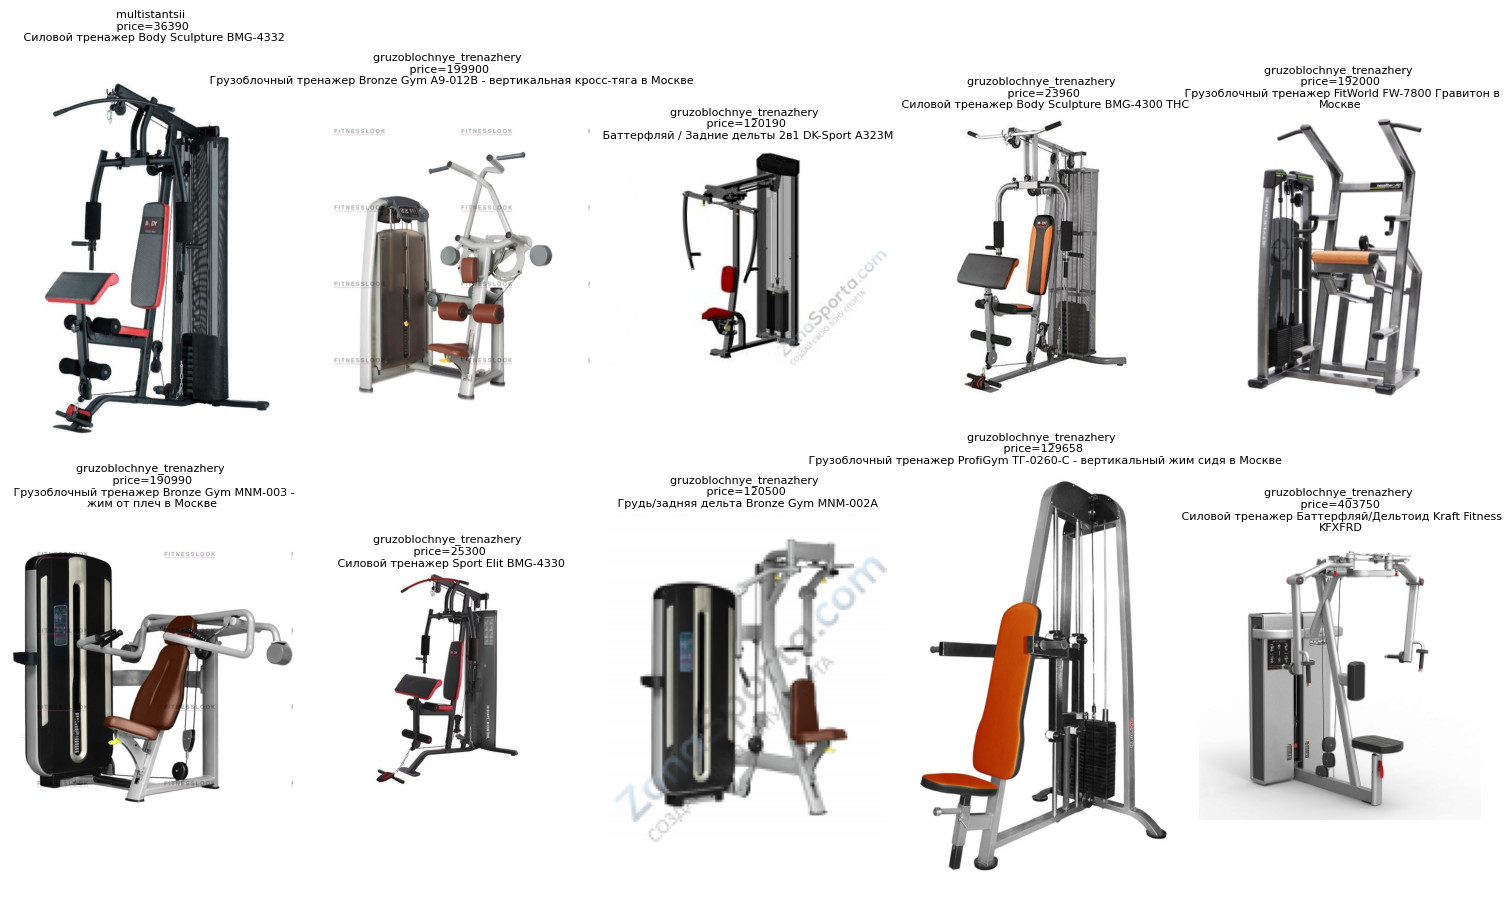

In [14]:
display_random_item(
    k=10,
    k_img=50,
    k_text=10,
    random_idx=621,
    method="combo",
    company_data=company_data,
    company_emb=company_emb_flat,
    database_emb=database_emb_flat,
    comparable_data=comparable_data,
    forest=forest,
    text_model=text_model,
    tokenizer=tokenizer,
    info_used="title_only",
)

In [15]:
calc_ann_metric_rerank(
    k_img=40,
    k_text=10,
    forest=forest,
    query_tensors=company_emb_flat,
    query_df=company_data,
    database_df=comparable_data,
    text_model=text_model,
    tokenizer=tokenizer,
    info_used="title_cat",
)

  0%|          | 0/984 [00:00<?, ?it/s]

grebnye_trenazhery acc at 10: 0.949
ellipticheskie_trenazhery acc at 10: 0.9973
velotrenazhery acc at 10: 0.995
begovye_dorozhki acc at 10: 0.9935
steppery acc at 10: 0.3891
trenazhery_na_svobodnykh_vesakh acc at 10: 0.8435
multistantsii acc at 10: 0.7458
Total acc at 10: 0.9036


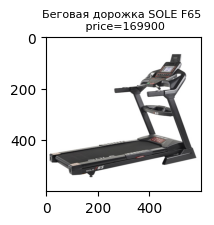

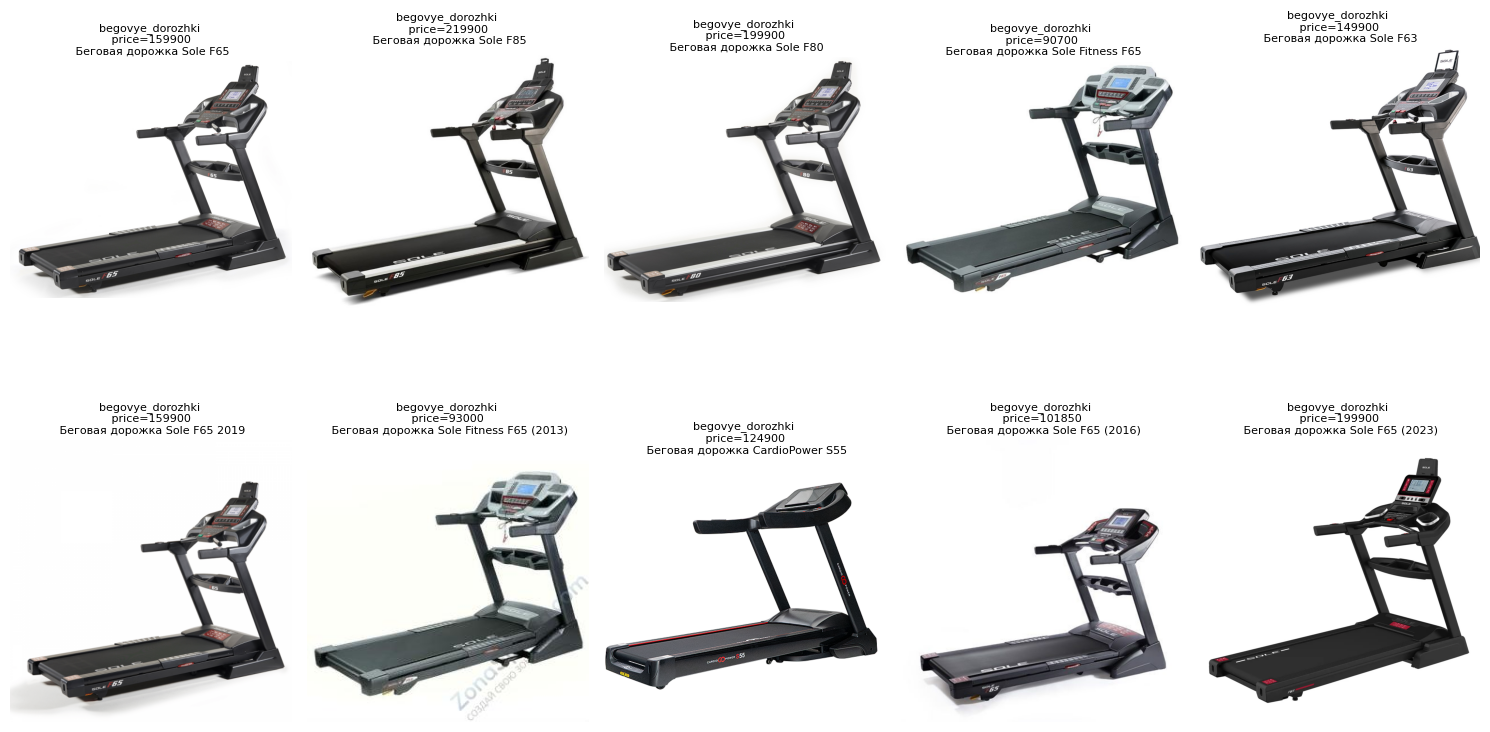

In [16]:
display_random_item(k=10, k_img=50, k_text=10, random_idx=0,
                    method='combo', company_data=company_data, company_emb=company_emb_flat,
                    database_emb=database_emb_flat, comparable_data=comparable_data,
                    forest=forest, text_model=text_model, tokenizer=tokenizer, info_used='title_only')

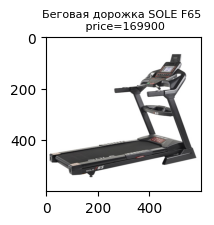

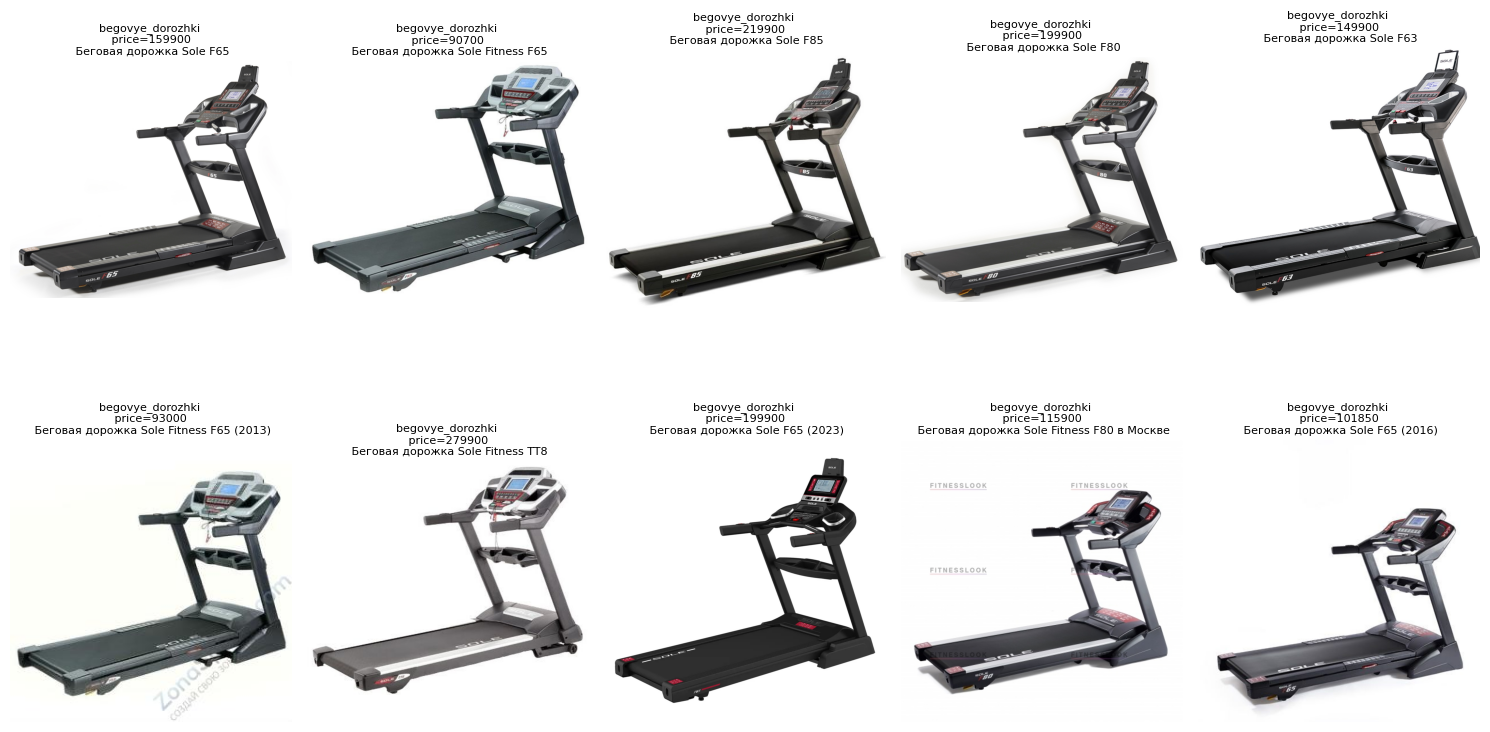

In [17]:
display_random_item(
    k=10,
    k_img=50,
    k_text=10,
    random_idx=0,
    method="combo",
    company_data=company_data,
    company_emb=company_emb_flat,
    database_emb=database_emb_flat,
    comparable_data=comparable_data,
    forest=forest,
    text_model=text_model,
    tokenizer=tokenizer,
    info_used="title_cat",
)

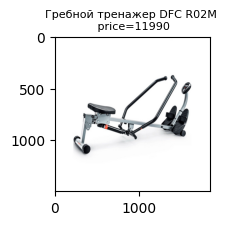

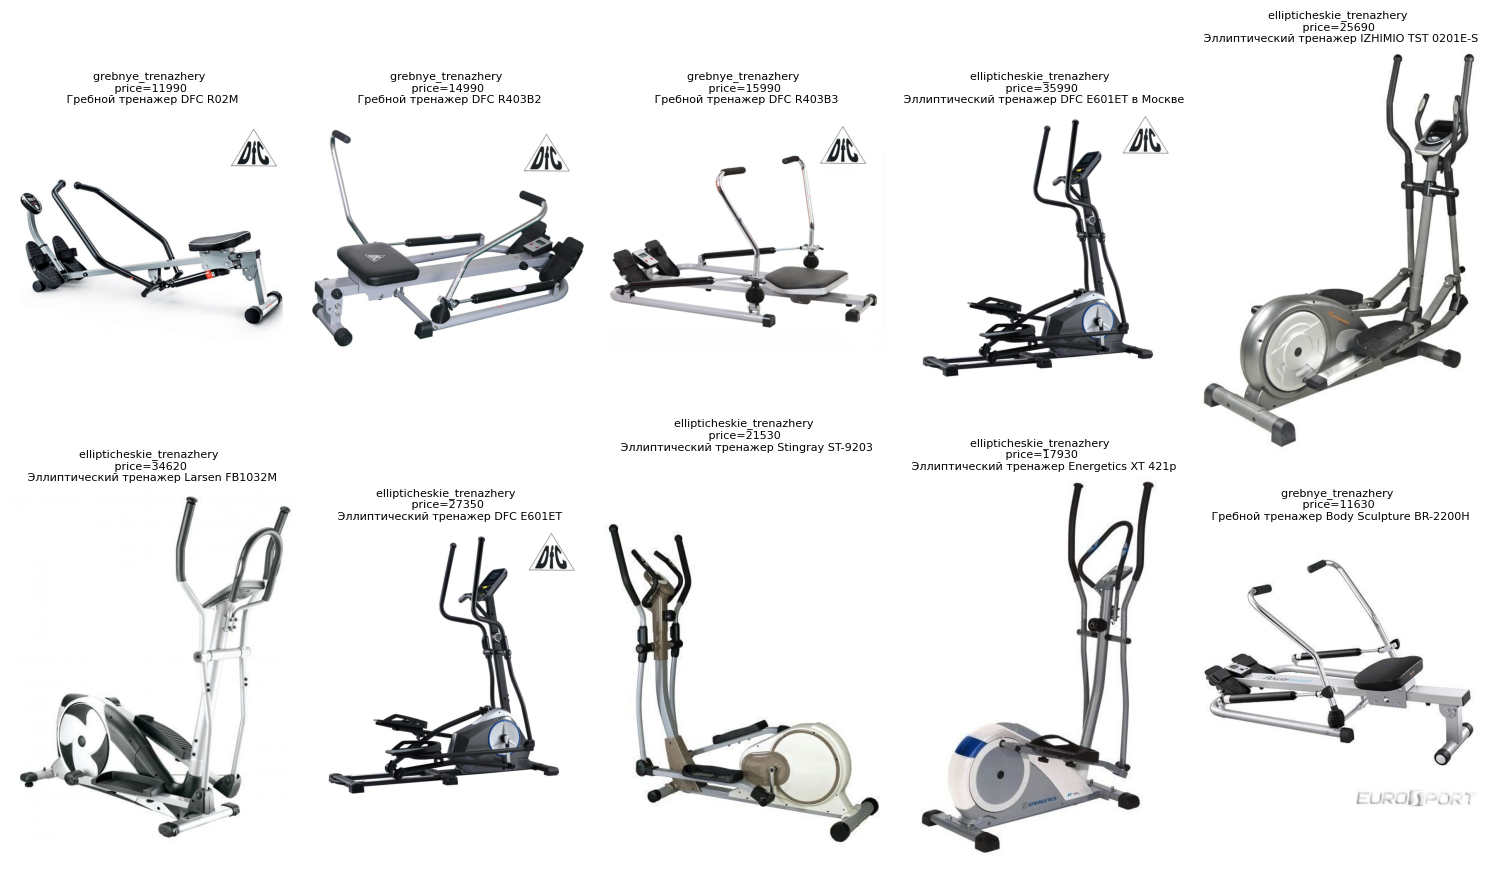

In [18]:
display_random_item(
    k=10,
    k_img=50,
    k_text=10,
    random_idx=500,
    method="combo",
    company_data=company_data,
    company_emb=company_emb_flat,
    database_emb=database_emb_flat,
    comparable_data=comparable_data,
    forest=forest,
    text_model=text_model,
    tokenizer=tokenizer,
    info_used="title_cat",
)

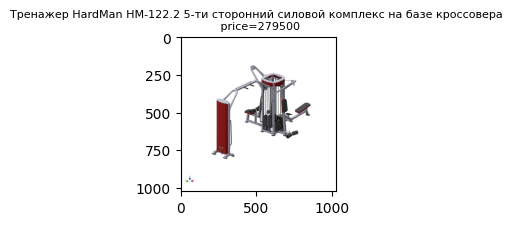

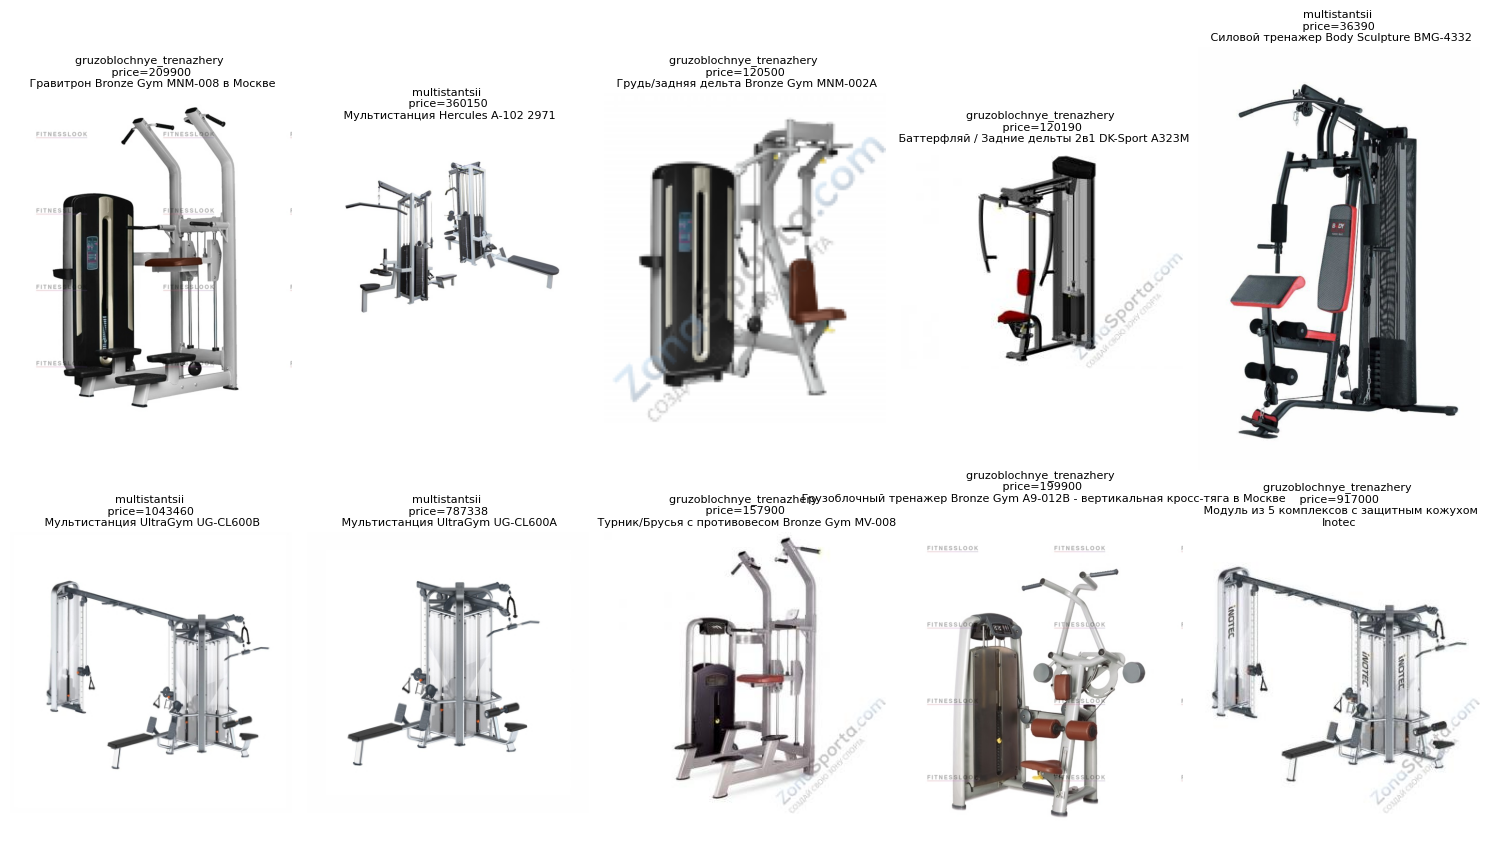

In [19]:
display_random_item(
    k=10,
    k_img=50,
    k_text=10,
    random_idx=621,
    method="combo",
    company_data=company_data,
    company_emb=company_emb_flat,
    database_emb=database_emb_flat,
    comparable_data=comparable_data,
    forest=forest,
    text_model=text_model,
    tokenizer=tokenizer,
    info_used="title_cat",
)

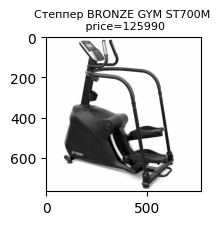

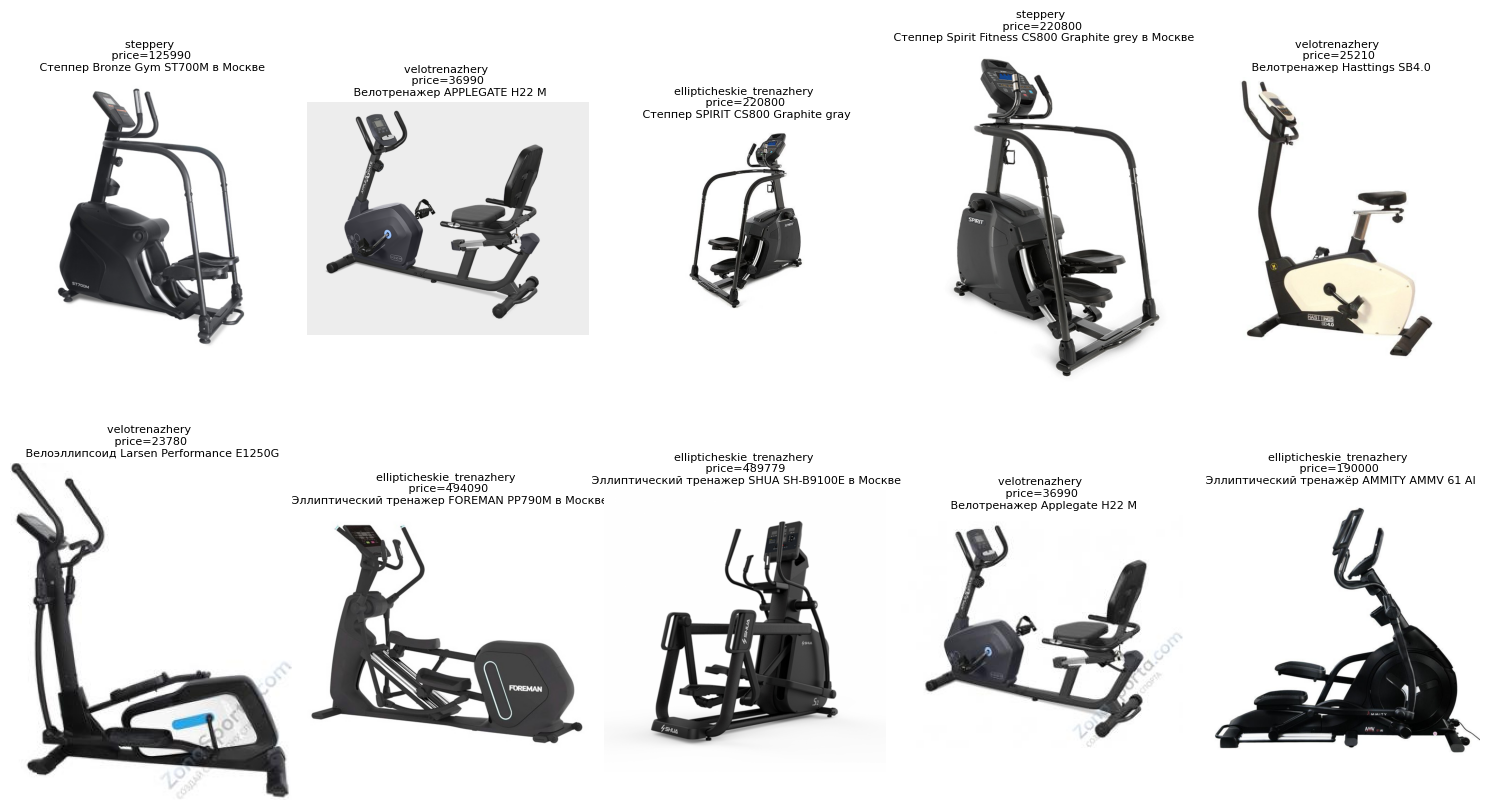

In [20]:
display_random_item(
    k=10,
    k_img=50,
    k_text=10,
    random_idx=626,
    method="combo",
    company_data=company_data,
    company_emb=company_emb_flat,
    database_emb=database_emb_flat,
    comparable_data=comparable_data,
    forest=forest,
    text_model=text_model,
    tokenizer=tokenizer,
    info_used="title_cat",
)